In [6]:
# Simple method to convert from liblinear format to fann format
def convert_liblinear_file(ll_filepath, fann_filepath):
    with open(ll_filepath, 'r') as ll_file:
        data = []
        for line in ll_file.readlines():
            fields = line.strip().split(" ")
            row = [int(fields[0])]
            for (i, field) in enumerate(fields[1:]):
                (colnum, value) = field.split(":")
                assert(int(colnum) == (i + 1))
                row.append(float(value))
            data.append(row)
    with open(fann_filepath, 'w') as fann_file:
        rows = len(data)
        cols = len(data[0]) -1
        fann_file.write("%s %s %s\n" % (rows, cols, 1))
        for row in data:
            is_cleaved = row[0]
            for feature in row[1:]:
                fann_file.write("%.12f " % (feature))
            fann_file.write("\n%d\n" % (is_cleaved))

In [7]:
from fann2 import libfann
import pandas as pd
import numpy as np

In [8]:
data_dir = "/workspace/chipper_data/chipper-0.3.0-data/"
train_data_path = data_dir + "train_data.fann"
test_data_path = data_dir + "test_data.fann"
neural_network_save_file = data_dir + "neural.net"

In [9]:
convert_liblinear_file(data_dir + "testing_data.ll", test_data_path)
convert_liblinear_file(data_dir + "training_data.ll", train_data_path)

In [10]:
from fann2 import libfann

train_data = libfann.training_data()
train_data.read_train_from_file(train_data_path)

num_input = train_data.num_input_train_data()
num_output = train_data.num_output_train_data()

alpha = 5.0 # Range of 2 to 10, below 5 might cause overfitting
num_hidden = train_data.length_train_data() / (alpha * (num_input  + num_output))

ann = libfann.neural_net()
ann.create_sparse_array(connection_rate=0.5, layers=(num_input, num_output))
ann.set_scaling_params(data=train_data, new_input_min=0, new_input_max=1, new_output_min=0, new_output_max=1)
ann.scale_train(data=train_data)
ann.set_learning_rate(0.7)
#ann.set_train_error_function(libfann.ERRORFUNC_LINEAR)
ann.set_activation_function_hidden(libfann.ELLIOT)
# Steepness= 0.5 ELLIOT AUC=0.88
ann.set_activation_steepness_output(0.5)
ann.set_activation_function_output(libfann.ELLIOT)


ann.train_on_data(data=train_data, desired_error=0.09, epochs_between_reports=5, max_epochs=500)
ann.save(neural_network_save_file)
ann.print_connections()
ann.print_parameters()

In [11]:
from fann2 import libfann

ann = libfann.neural_net()
ann.create_from_file(neural_network_save_file)

test_data = libfann.training_data()
test_data.read_train_from_file(test_data_path)
ann.scale_train(data=test_data)

ann.reset_MSE()
input=test_data.get_input()
output=test_data.get_output()

prediction_file = data_dir + "neural_predictions.csv"
with open(prediction_file, 'w') as predict_file:
    predict_file.write(",actual,predicted\n")
    for i in range(len(input)):
        predict = ann.test(input[i], output[i])
        predict_file.write("%d,%d,%f\n" % (i, int(output[i][0]), predict[0]))
print "MSE error on test data: %f" % ann.get_MSE()


MSE error on test data: 0.145478


/Users/matt/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:516: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(var_yt * var_yp)


** Cutoff= 0.37 (MCC=0.612) **
             precision    recall  f1-score   support

          0       0.83      0.77      0.80       208
          1       0.79      0.84      0.81       208

avg / total       0.81      0.81      0.81       416

NN: sensitivity(recall)=83.7, specificity=77.4, precision=78.7


<IPython.core.display.Javascript object>


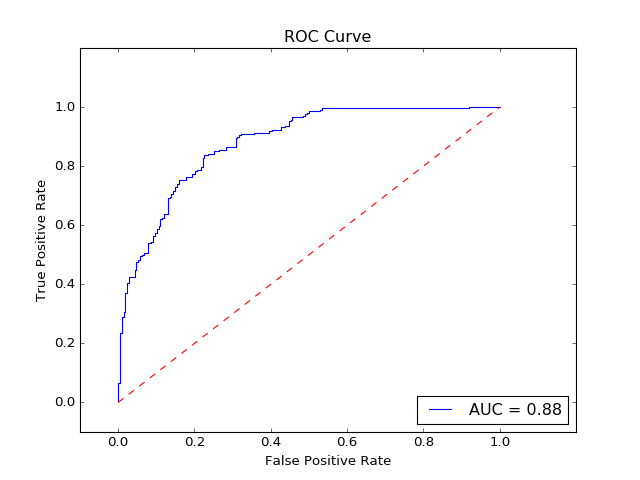

In [13]:
import pandas as pd

df = pd.DataFrame.from_csv(prediction_file)
real = df.actual.astype("int")
predicted = df.predicted

from sklearn.metrics import classification_report, matthews_corrcoef, confusion_matrix

classification_vector = lambda cutoff: [1 if pred >= cutoff else 0 for pred in predicted]

def find_best_mcc():
    best_mcc = 0.0
    best_cutoff = 0.0
    for i in range(1, 100):
        pred_cutoff = i/100.0
        mcc = matthews_corrcoef(real, classification_vector(pred_cutoff))
        if (mcc > best_mcc):
            best_mcc = mcc
            best_cutoff = pred_cutoff
    return (best_cutoff, best_mcc)

(best_cutoff, best_mcc) = find_best_mcc()
print "** Cutoff= %.2f (MCC=%.3f) **" % (best_cutoff, best_mcc)
print classification_report(real, classification_vector(best_cutoff))

def print_metrics(name, actual, predicted):
    ((tn, fp), (fn, tp)) = confusion_matrix(actual, predicted)    
    sensitivity = 100.0 * tp / (tp + fn)
    specificity = 100.0 * tn / (tn + fp)
    precision = 100.0 * tp / (tp + fp)
    print "%s: sensitivity(recall)=%.1f, specificity=%.1f, precision=%.1f" % (name, sensitivity, specificity, precision)

print_metrics("NN", real, classification_vector(best_cutoff))

%matplotlib notebook
import matplotlib.pyplot as plt
from sklearn import svm, metrics

fpr, tpr, thresholds = metrics.roc_curve(real, predicted, pos_label=1)
roc_auc = metrics.roc_auc_score(real, predicted, average='macro', sample_weight=None)
plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f'% (roc_auc))
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [14]:
def fetch_neural_connections():
    with open(neural_network_save_file, 'r') as network_file:
        data = []
        for line in network_file.readlines():
            if line.startswith("connections"):
                (key, value) = line.split("=")
                for record in value.strip()[1:-1].split(") ("):
                    (neuron, weight) = record.split(", ")
                    data.append((int(neuron), float(weight)))
        df = pd.DataFrame(data)
        df.columns = ["connected_to_neuron", "weight"]
        return df
                   
df = fetch_neural_connections()
df["abs_weight"] = df.weight.abs()
df["position"] = df.connected_to_neuron.div(50).astype("int")
df["measure"] = df.connected_to_neuron.mod(50)
# 0 - 17 (18 values)
df["hydrophic"] = df.measure.le(17)
# 36 - 49 (15 values)
df["electronic"] = df.measure.ge(36)
# 18 - 35 (17 values)
df["steric"] = (df.hydrophic | df.electronic) == False

total_weight = df.abs_weight.sum()
df["perc_weight"] = df.abs_weight / total_weight * 100
df = df[df.perc_weight > 0.1]
df.sort_values(by=["perc_weight"], ascending=False)


,connected_to_neuron,weight,abs_weight,position,measure,hydrophic,electronic,steric,perc_weight
454,453,2.098767,2.098767,9,3,True,False,False,1.627395
488,487,-2.083853,2.083853,9,37,False,True,False,1.615831
460,459,-1.651490,1.651490,9,9,True,False,False,1.280574
309,308,1.444614,1.444614,6,8,True,False,False,1.120162
449,448,-1.354448,1.354448,8,48,False,True,False,1.050246
149,148,1.289342,1.289342,2,48,False,True,False,0.999763
338,337,1.256546,1.256546,6,37,False,True,False,0.974332
364,363,-1.216270,1.216270,7,13,True,False,False,0.943102
500,499,1.169001,1.169001,9,49,False,True,False,0.906450
260,259,1.031897,1.031897,5,9,True,False,False,0.800139
